In [0]:
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
#!pip install periodictable
import periodictable
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from pathlib import Path
import re
import json

In [2]:
samples_df = pd.read_csv('simulated_mineral_samples.csv')
samples_df.head()

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0,0,0,268,69,0,4,Millerite
1,0,0,0,109,74,0,4,Millerite
2,0,1,0,159,78,0,2,Millerite
3,0,0,0,323,76,0,3,Millerite
4,0,1,0,240,72,0,4,Millerite


In [0]:
X = samples_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
Y = samples_df['mineral']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [4]:
#mod = SVC(kernel='rbf', max_iter=300)
mod = RandomForestClassifier(100, max_depth=5, n_jobs=-1)
mod.fit(X_train, Y_train)
(mod.predict(X_train) == Y_train).mean(), (mod.predict(X_test) == Y_test).mean()

(0.9525, 0.9547857142857142)

In [5]:
np.argmax(mod.predict_proba(X_test[:5]), axis=1)

array([0, 6, 4, 2, 5])

In [0]:
# Define where your images are

root = Path('gdrive/My Drive/meteorite_mineral_mapper')
image_path = root / 'dataset_1_opaques'

In [7]:
#standard_minerals = [i for i in list(image_path.glob('*_mask.tif')) if 'obj' not in i.name]
#standards = [{'name': s.name.split('_')[2].split('.')[0], 'image': imread(s)} for s in image_path.glob('standards_32*.tif')]

images = [{'element': s.name.split('_')[2].split('.')[0], 'image': imread(s)} for s in image_path.glob('obj1_32bt_*')]
images

[{'element': 'Al', 'image': array([[25, 45, 51, ...,  8,  7,  5],
         [15, 19, 47, ...,  5, 11, 11],
         [ 8,  8, 18, ...,  7, 15,  8],
         ...,
         [ 0,  0,  5, ...,  0,  0,  0],
         [ 2,  3,  2, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  4]], dtype=int32)},
 {'element': 'Ca', 'image': array([[26, 15, 11, ...,  2,  6,  0],
         [37, 29, 21, ...,  5,  0,  0],
         [46, 45, 29, ...,  3,  7,  6],
         ...,
         [ 9, 13, 11, ...,  0,  2,  0],
         [ 4,  3,  3, ...,  2,  0,  2],
         [ 2,  0,  4, ...,  0,  0,  0]], dtype=int32)},
 {'element': 'Cr', 'image': array([[25, 17, 12, ..., 11,  9,  9],
         [15, 15, 10, ...,  3,  4,  9],
         [23, 20, 14, ...,  7,  8, 11],
         ...,
         [10,  6, 25, ...,  3,  7,  2],
         [10,  6, 11, ...,  5,  7, 10],
         [11,  9,  7, ...,  2,  4,  6]], dtype=int32)},
 {'element': 'Fe', 'image': array([[ 15,  12,   9, ...,  75,  81,  83],
         [  6,   7,  11, ...,  82,  72, 

In [0]:
columns = []
pixels = []
for element in images:
  columns.append(element['element'])
  pixels.append(element['image'].flatten())

In [9]:
image_pixels_df = pd.DataFrame(np.dstack(pixels)[0], columns=columns)
image_pixels_df = image_pixels_df.reset_index().rename(columns={'Pho': 'P', 'Sul': 'S', 'index': 'order'})
image_pixels_df.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti
0,0,25,26,25,15,65,0,0,332,0,9
1,1,45,15,17,12,26,0,0,229,0,12
2,2,51,11,12,9,5,0,0,262,0,8
3,3,62,5,12,8,5,0,5,278,0,12
4,4,80,4,6,5,6,0,0,313,0,9


In [0]:
X = image_pixels_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
image_pixels_df['predicted_element'] = mod.predict(X)

In [11]:

results = image_pixels_df.merge(
    pd.Series(mod.classes_, name='predicted_element').reset_index().rename(columns={'index': 'element_index'}),
    on='predicted_element'
).sort_values('order')
results.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,predicted_element,element_index
0,0,25,26,25,15,65,0,0,332,0,9,Pyroxene,4
1,1,45,15,17,12,26,0,0,229,0,12,Pyroxene,4
2,2,51,11,12,9,5,0,0,262,0,8,Pyroxene,4
3,3,62,5,12,8,5,0,5,278,0,12,Pyroxene,4
4,4,80,4,6,5,6,0,0,313,0,9,Pyroxene,4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


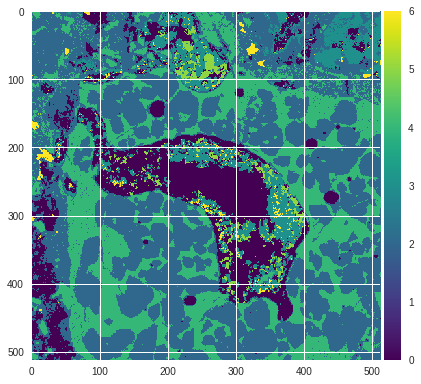

In [12]:
imshow(results['element_index'].reshape((512, 512)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


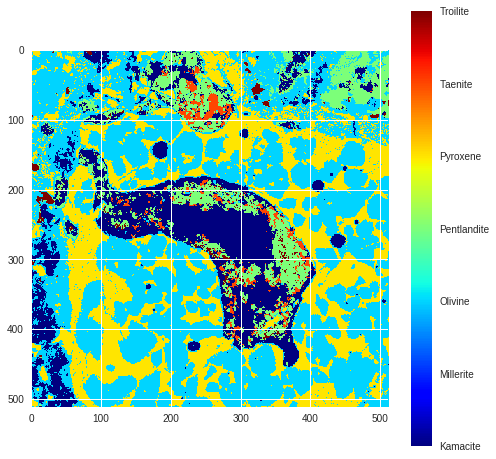

In [20]:
figure, ax = plt.subplots(figsize=(8,8))
i = ax.imshow(
    results['element_index'].reshape((512, 512)),
    cmap='jet'
)
cbar = figure.colorbar(i, ticks=range(len(mod.classes_)))
cbar.ax.set_yticklabels(mod.classes_)
ax.legend()

In [17]:
figure.colorbar()

mod.classes_

array(['Kamacite', 'Millerite', 'Olivine', 'Pentlandite', 'Pyroxene',
       'Taenite', 'Troilite'], dtype=object)